# Rekko challenge 2019

```
                           /$$$$$$$  /$$$$$$$$ /$$   /$$ /$$   /$$  /$$$$$$ 
                          | $$__  $$| $$_____/| $$  /$$/| $$  /$$/ /$$__  $$
                          | $$  \ $$| $$      | $$ /$$/ | $$ /$$/ | $$  \ $$
                          | $$$$$$$/| $$$$$   | $$$$$/  | $$$$$/  | $$  | $$
                          | $$__  $$| $$__/   | $$  $$  | $$  $$  | $$  | $$
                          | $$  \ $$| $$      | $$\  $$ | $$\  $$ | $$  | $$
                          | $$  | $$| $$$$$$$$| $$ \  $$| $$ \  $$|  $$$$$$/
                          |__/  |__/|________/|__/  \__/|__/  \__/ \______/ 
                                                                            
```

Welcome to the [Okko](http://okko.tv) Rekko Challenge 2019.

Solution by Alex Ekimenko (MisterPo)

Stacking (CatBoost) of Implicit.ALS & NN CF Models

In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
#from tqdm.notebook import tqdm
from pprint import pprint
from implicit.als import AlternatingLeastSquares
import dataset_utils as du
%matplotlib inline

### Load Data

In [2]:
ds_catalogue = du.processCatalogue()
test_users = du.processTestUsers()
transactions = du.processTransactions(use_cashe=True)
ratings = du.processRatings()
bookmarks = du.processBookmarks()

In [7]:
bookmarks

,user_uid,element_uid,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07
3,301135,2693,4.430516e+07
4,301135,2181,4.430515e+07
...,...,...,...
948211,524752,2557,4.173079e+07
948212,524752,8919,4.173077e+07
948213,5174,3637,4.173076e+07
948214,161137,9700,4.173076e+07


In [14]:
tr = du.processTransactions(use_cashe=True)
tr_train, tr_val = du.trainvalTransactions(tr, border=0.95)
# these params perform best:
rating_params = {'bookmarked': 5, 'purchased': 10, 
                             'watched_movie': 8, 'watched_series': 9, 'watch_failed': 1}
ds_val = du.makeTarget(tr_val, du.processCatalogue(), du.processBookmarks(), du.processRatings(), params = rating_params)


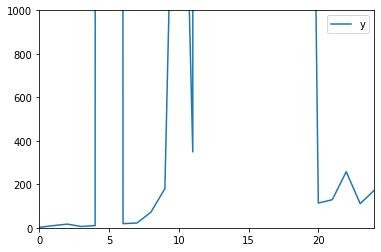

In [26]:
ds_val['y'].value_counts().reset_index().sort_values(by='index').reset_index()[['y']].plot(ylim=[0,1000])

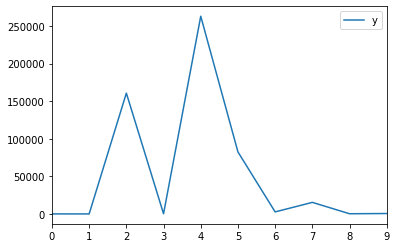

In [18]:
ds_val['y'].value_counts(bins=10).reset_index().sort_values(by='index').reset_index()[['index', 'y']].plot()

### Train Dataset

In [ ]:


# ALS1 -> ratings predict
# ALS2 -> transactions
# ALS3 -> bookmark predict
# via NN

# step 1
# make NN CF and test it for score on sandbox



### Baseline

Для начала построим список элементов, которые тестовые пользователи уже купили или посмотрели по подписке: они не смогут купить их второй раз, а просмотр по подписке второй раз маловероятен, поэтому мы захотим отфильтровать такие элементы из финального ответа.

Точно так же можно поступить и с рейтингами и добавлениями в избранное, если это будет казаться правильным.

In [63]:
from collections import defaultdict

filtered_elements = defaultdict(set)

for user_uid, element_uid in tqdm.tqdm(transactions.loc[:, ['user_uid', 'element_uid']].values):
    if user_uid not in test_users:
        continue
    filtered_elements[user_uid].add(element_uid)

100%|██████████| 9643012/9643012 [00:13<00:00, 712012.73it/s]


---

Для примера мы воспользуемся методом K ближайших соседей, реализованным в библиотеке `implicit`. В качестве данных используем только информацию о рейтингах.

Необходимо построить разреженную матрицу, где строкам будут соответствовать элементы, столбцам — пользователи, а на пересечении пользователя и элемента будет находиться количественная оценка степени их взаимодействия, если таковое имело место.

Не забудем добавить `1` к рейтингу, чтобы избежать деления на ноль во время вычисления `tf-idf`.

In [60]:
ratings['user_uid'].astype('category')

0         571252
1          63140
2         443817
3         359870
4         359870
           ...  
438785    170707
438786     32659
438787    353752
438788    492350
438789    374752
Name: user_uid, Length: 438790, dtype: category
Categories (104563, uint64): [1, 3, 14, 16, ..., 593465, 593467, 593478, 593486]

In [64]:
ratings['user_uid'] = ratings['user_uid'].astype('category')
ratings['element_uid'] = ratings['element_uid'].astype('category')

ratings_matrix = sp.coo_matrix(
    (ratings['rating'].astype(np.float32) + 1,
        (
            ratings['element_uid'].cat.codes.copy(),
            ratings['user_uid'].cat.codes.copy()
        )
    )
)

ratings_matrix = ratings_matrix.tocsr()

In [65]:
sparsity = ratings_matrix.nnz / (ratings_matrix.shape[0] * ratings_matrix.shape[1])
print('Sparsity: %.6f' % sparsity)

Sparsity: 0.000558


Обучить модель крайне просто.

In [66]:
from implicit.nearest_neighbours import TFIDFRecommender

model = TFIDFRecommender()
model.fit(ratings_matrix)

In [67]:
from implicit.als import AlternatingLeastSquares

os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
factors = 20 # из-за Memory Errors. В original было =64
model1 = AlternatingLeastSquares(factors=factors, iterations=100)

In [68]:
model1.fit(item_users=ratings_matrix)

In [69]:
ratings_matrix_T = ratings_matrix.T.tocsr()

Отображения из оригинальной категории во внутреннюю пригодится нам в дальнейшем.

In [70]:
user_uid_to_cat = dict(zip(
    ratings['user_uid'].cat.categories,
    range(len(ratings['user_uid'].cat.categories))
))

In [71]:
element_uid_to_cat = dict(zip(
    ratings['element_uid'].cat.categories,
    range(len(ratings['element_uid'].cat.categories))
))

In [72]:
filtered_elements_cat = {k: [element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

---

В метод `model.recommend` мы передаём идентификатор пользователя, который получаем обратным преобразованием из категории, транспонированную матрицу взаимодействий, число необходимых рекомендаций и список элементов, которые мы договорились фильтровать из ответа.

Возвращает метод список пар (`element_cat`, `score`), отсортированный по вторым элементам. Из него необходимо достать все первые элементы пар и из категории преобразовать их к `element_uid`.

**Важно:** Не все тестовые пользователи есть в `ratings.csv` и не все из них есть в `transactions.csv`. Используя только один источник данных мы не можем построить полное предсказание. Такой ответ с неполным числом пользователей бдет принят системой, но при вычислении средней метрики метрика для отсутствующих пользователей будет принята равной нулю.

In [73]:
result = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recs = model.recommend(
        user_cat,
        ratings_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    result[user_uid] = [int(ratings['element_uid'].cat.categories[i]) for i, _ in recs]

100%|██████████| 50000/50000 [00:01<00:00, 31378.93it/s]


In [76]:
# ALS

resultals = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    recsals = model1.recommend(
        user_cat,
        ratings_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    resultals[user_uid] = [int(ratings['element_uid'].cat.categories[i]) for i, _ in recsals]

100%|██████████| 50000/50000 [00:03<00:00, 12747.50it/s]


In [77]:
len(resultals)

13251

Используя только информацию о рейтингах мы смогли построить предсказание для `13251` из `50000` тестовых пользователей. Ровно в таком виде ответы и стоит сохранить для отправки.

In [78]:
with open('answer_als.json', 'w') as f:
    json.dump(resultals, f)

### ALS Transactions

In [80]:
features_list = ['element_uid', 'user_uid', 'watched_time', 'consumption_mode']
trans_ds = transactions[features_list]

In [86]:
tds1 = trans_ds.merge(ds_catalogue[['element_id', 'target_time']], 
                          left_on='element_uid', right_on='element_id', how = 'left')

In [88]:
def makeTarget(row):
    y = 0
    if row['consumption_mode'] in set(['P','R']):
        y = 1
    else:
        if row['watched_time'] >= row['target_time']:
            y = 1
            
    return y        

tds1['y'] = tds1.apply(lambda row: makeTarget(row), axis=1)

In [99]:
tds2 = tds1[tds1['y']==1][['element_uid', 'user_uid']]
del tds1

In [116]:
tds2['cnt'] = 1

In [117]:
tds3 = tds2.groupby(['element_uid','user_uid']).agg({'cnt': np.size}).reset_index()

In [120]:
del tds2

In [121]:
tds3['user_uid'] = tds3['user_uid'].astype('category')
tds3['element_uid'] = tds3['element_uid'].astype('category')

t_matrix = sp.coo_matrix(
    (tds3['cnt'].astype(np.float32) + 1,
        (
            tds3['element_uid'].cat.codes.copy(),
            tds3['user_uid'].cat.codes.copy()
        )
    )
)

t_matrix = t_matrix.tocsr()

In [123]:
sparsity = t_matrix.nnz / (t_matrix.shape[0] * t_matrix.shape[1])
print('Sparsity: %.6f' % sparsity)

Sparsity: 0.001714


In [124]:
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
factors = 20 # из-за Memory Errors. В original было =64
model2 = AlternatingLeastSquares(factors=factors, iterations=100)

In [125]:
model2.fit(item_users=t_matrix)

In [126]:
t_matrix_T = t_matrix.T.tocsr()

In [127]:
t_user_uid_to_cat = dict(zip(
    tds3['user_uid'].cat.categories,
    range(len(tds3['user_uid'].cat.categories))
))
t_element_uid_to_cat = dict(zip(
    tds3['element_uid'].cat.categories,
    range(len(tds3['element_uid'].cat.categories))
))

In [128]:
t_filtered_elements_cat = {k: [t_element_uid_to_cat.get(x, None) for x in v] for k, v in filtered_elements.items()}

In [130]:
t_result = {}

for user_uid in tqdm.tqdm(test_users):
    # transform user_uid to model's internal user category
    try:
        user_cat = t_user_uid_to_cat[user_uid]
    except LookupError:
        continue
    
    # perform inference
    t_recs = model2.recommend(
        user_cat,
        t_matrix_T,
        N=20,
        filter_already_liked_items=True,
        filter_items=t_filtered_elements_cat.get(user_uid, set())
    )
    
    # drop scores and transform model's internal elelemnt category to element_uid for every prediction
    # also convert np.uint64 to int so it could be json serialized later
    t_result[user_uid] = [int(tds3['element_uid'].cat.categories[i]) for i, _ in t_recs]

100%|██████████| 50000/50000 [00:16<00:00, 2985.60it/s]


In [131]:
len(t_result)

49814

In [132]:
with open('answer_t.json', 'w') as f:
    json.dump(t_result, f)